# 使用DNN进行股票价格预测

本实例基于文章`Predicting Stock Prices with Deep Neural Networks`进行实践，原文链接：[link](https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/)

由于金融市场自然地由股票价格的历史序列组成，越来越多的量化研究人员和金融专业人士使用LSTM（长短期记忆网络）来建模和预测市场价格走势。

- 安装python依赖
- 准备数据：获取数据
- 准备数据：归一化原始数据
- 数据准备：生成训练和验证数据集
- 定义LSTM模型
- 模型训练
- 模型评估
- 预测未来股票价格

在这个项目结束时，您将拥有一个功能齐全的LSTM模型，它可以根据历史价格变动预测未来的股票价格，并且所有内容都在一个Python文件中。

## 安装python依赖

建议使用Python3.6以上的环境

需要安装的依赖包： numpy, pytorch, matplotlib, akshare

**Note**:暂时先使用akshare获取数据，今后使用postgres中的数据进行处理

In [124]:
! pip install numpy torch matplotlib akshare seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [125]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import akshare as ak
print("all libraries loaded")

all libraries loaded


## 准备数据：获取数据

本项目会训练一个LSTM模型用于预测股票价格趋势。首先我们需要获取股票的历史数据用来训练模型。
我们将会使用万科Ａ(000002) 30年的数据进行股票预测（1992.1~ 2024.1)，此处使用后复权数据用于模型

In [126]:
symbol = "000002" #0002 万科A  000001 平安银行 600603 广汇物流

In [127]:
start_date = "19920101"
end_date = "20240101"

In [128]:
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date, adjust="hfq")
num_data_points=len(stock_zh_a_hist_df)
stock_zh_a_hist_df
num_data_points

7571

In [129]:
data_date = stock_zh_a_hist_df['日期']
data_close_price = stock_zh_a_hist_df['收盘']
data_close_price

0         20.21
1         20.12
2         20.30
3         20.75
4         20.39
         ...   
7566    2518.88
7567    2501.87
7568    2501.87
7569    2547.68
7570    2539.83
Name: 收盘, Length: 7571, dtype: float64

此处数据可视化借鉴 [Python量化数据可视化](https://www.runoob.com/python-qt/qt-views.html)，使用seaborn和matplotlib

In [130]:
from pylab import mpl
mpl.rcParams["font.sans-serif"] = ["Arial Unicode MS"] ## mac

plt.rcParams['font.family']=['Arial Unicode MS'] ## mac
mpl.rcParams["axes.unicode_minus"] = False

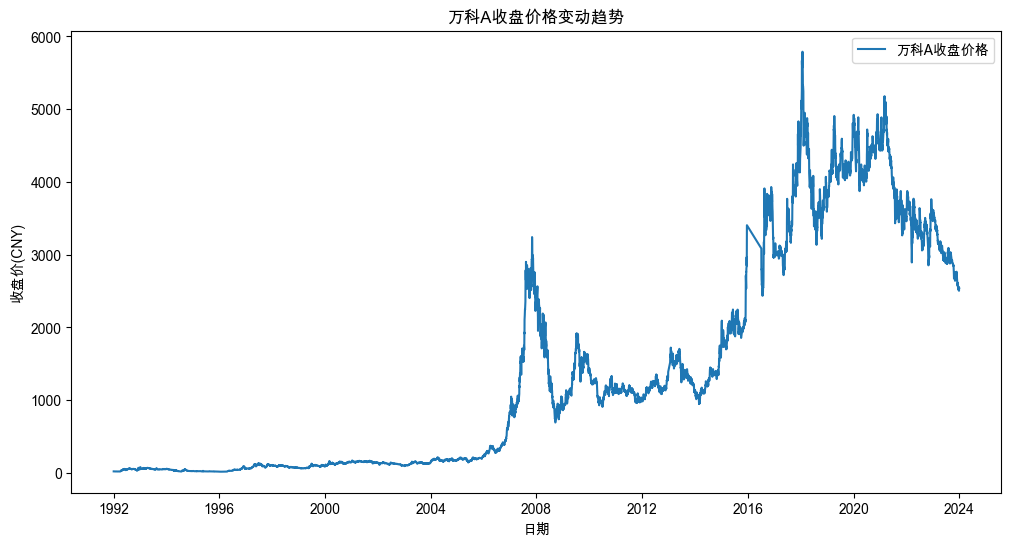

In [131]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_date, y=data_close_price, label='万科A收盘价格')
plt.title('万科A收盘价格变动趋势')
plt.xlabel('日期')
plt.ylabel('收盘价(CNY)')
plt.legend()
plt.show()

> issue: 不支持中文，UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

https://blog.csdn.net/weixin_46474921/article/details/123783987
https://blog.csdn.net/me_andy/article/details/126038692
https://www.cnblogs.com/ghj1976/p/matplotlib-hui-tu-zhong-wen-luan-ma-wen-ti.html

**rcParams方法**

在前面增加下面代码。
```python
from pylab import mpl
mpl.rcParams["font.sans-serif"] = ["Arial Unicode MS"] ## mac

plt.rcParams['font.family']=['Arial Unicode MS'] ## mac


mpl.rcParams["font.sans-serif"] = ["SimHei"] ## win

plt.rcParams['font.family']=['SimHei'] ## win
```

**局部设置**
这里我们演示加载自己的字体文件，设置指定的字体。

比如：
思源黑体是 Adobe 与 Google 推出的一款开源字体。

官网：https://source.typekit.com/source-han-serif/cn/

GitHub 地址：https://github.com/adobe-fonts/source-han-sans/tree/release/OTF/SimplifiedChinese

我这里用的是 SourceHanSansSC-Bold.otf

演示代码
```python
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
myfont = matplotlib.font_manager.FontProperties(fname=r"SourceHanSansSC-Bold.otf", size=14)
```

## 准备数据：归一化原始数据

使用梯度下降作为优化技术的机器学习算法（例如我们的LSTM算法）需要对数据进行缩放。这是因为模型中的特征值会影响梯度下降的步长，可能会以意想不到的方式偏斜LSTM模型。

这就是**数据归一化**的用武之地。归一化可以提高模型的准确性，并帮助梯度下降算法更快地收敛。通过将输入数据置于相同的尺度并减少其方差，人工神经网络中的权重不会浪费在归一化任务上，这意味着LSTM模型可以更有效地从数据中学习并在网络中存储模式。此外，LSTM本质上对输入数据的尺度很敏感。出于上述原因，归一化数据是至关重要的。

由于股票价格可以从几十到数百甚至数千美元不等——以IBM为例，每股在40到160美元之间——我们将在股票价格上执行归一化，以在将数据输入LSTM模型之前标准化这些值的范围。下面的代码片段将数据重新缩放为均值为0，标准差为1。

In [132]:
import pandas as pd


class Normalizer:
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        # Convert Series to NumPy array if input is a Series
        if isinstance(x, pd.Series):
            x = x.values
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu
    
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)
normalized_data_close_price

array([-0.88587774, -0.88593727, -0.88581821, ...,  0.75551209,
        0.78581119,  0.78061914])

> issue: ValueError: the 'keepdims' parameter is not supported in the pandas implementation of mean()

原因是输入的数据类型是pd.Series, 而不是numpy的数组，需要将其转换成数组，添加如下代码
```python
  # Convert Series to NumPy array if input is a Series
if isinstance(x, pd.Series):
    x = x.values
```


## 数据准备：生成训练和验证数据集

监督学习方法（如 LSTM）通过学习输入变量（X）与输出变量（Y）之间的映射函数来进行学习。可以将从训练数据集中学习的过程视为一个教师监督学习的过程，其中教师知道所有正确的答案。

在这个项目中，我们将训练模型，以根据过去 20 天的收盘价格预测第 21 天的收盘价格。选择 20 天作为输入的原因有以下几点：

在自然语言处理任务中使用 LSTM 模型时，句子的单词数通常在 15 到 20 个之间。
梯度下降的考虑：对非常长的输入序列进行反向传播可能会导致梯度消失（稍后会详细介绍）。
较长的序列往往需要更长的训练时间。
在将数据集转换为输入特征和输出标签后，我们的 X 的形状为 (7551, 20)，其中 5388 为行数，每行包含过去 20 天价格的序列。对应的 Y 数据形状为 (7551,)，与 X 中的行数匹配。

我们还将数据集分成两部分，分别用于训练和验证。我们将数据以 80:20 的比例分割——80% 的数据用于训练，其余 20% 用于验证我们模型在预测未来价格方面的性能。（或者，另一种常见做法是将初始数据分为训练集、验证集和测试集，按 70/20/10 的比例分配，其中测试数据集在训练过程中完全不使用。), 大致来说，2017 年之前的数据用于训练，而 2017 年之后的数据用于验证模型性能。

In [133]:
window_size_use = 20
train_split_size = 0.8
training_device= 'cpu' # "cuda" or "cpu"
training_batch_size = 64
training_num_epoch = 100
training_learning_rate = 0.01
training_scheduler_step_size = 40
model_input_size = 1
model_num_lstm_layers = 2
model_lstm_size = 32
model_dropout = 0.2

In [134]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output


data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=window_size_use)
data_y = prepare_data_y(normalized_data_close_price, window_size=window_size_use)
len(data_x_unseen)

20

In [135]:
split_index = int(data_y.shape[0]*train_split_size)
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]
print(split_index)

6040


In [136]:
to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[20:split_index+window_size_use] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+window_size_use:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)


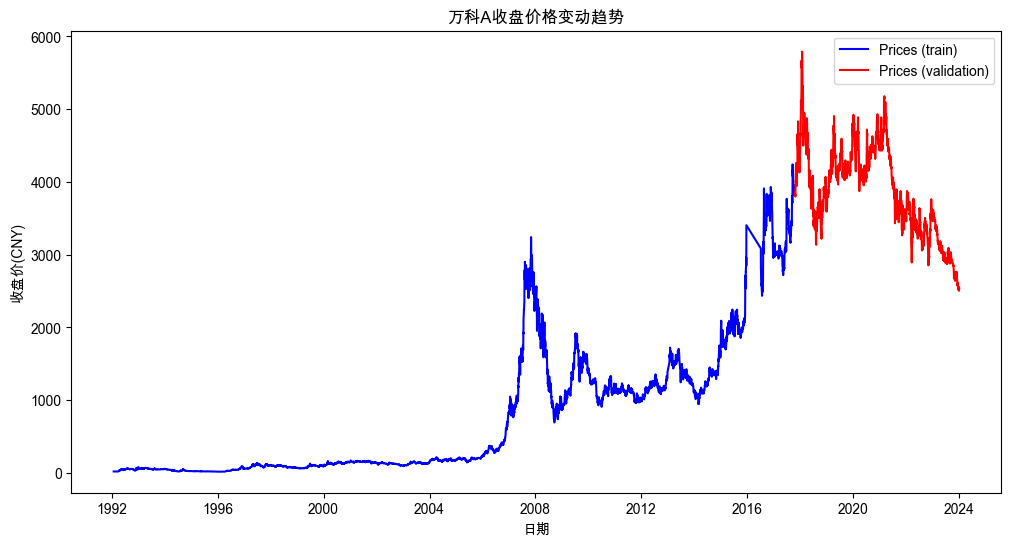

In [137]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_date, y=to_plot_data_y_train, label='Prices (train)', color='blue')
sns.lineplot(x=data_date, y=to_plot_data_y_val, label='Prices (validation)', color='red')
plt.title('万科A收盘价格变动趋势')
plt.xlabel('日期')
plt.ylabel('收盘价(CNY)')
plt.legend()
plt.show()

我们将使用 [PyTorch](https://pytorch.org/) 框架来训练我们的模型，这是一种用 Python 编写的机器学习库。PyTorch 数据加载工具的核心是 [DataLoader](https://pytorch.org/docs/stable/data.html) 类，它是一种高效的数据生成方案，在训练过程中可以充分利用计算机的图形处理单元（GPU）的全部潜力（如果适用的话）。`DataLoader` 需要 [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  对象来定义加载的数据。`Dataset` 是一种映射样式的数据集，它实现了 `__getitem__()` 和 `__len__()` 协议，并表示从索引到数据样本的映射。

In [138]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, shuffle=True)
val_dataloader = DataLoader(dataset_val, shuffle=True)

Train data shape (6040, 20, 1) (6040,)
Validation data shape (1511, 20, 1) (1511,)


## 定义LSTM模型

随着训练和评估数据的完全归一化和准备完毕，我们准备构建我们的 LSTM 模型！

如前所述，LSTM 是一种专门的人工神经网络架构，能够从历史数据序列中“记住”模式，并将这些模式推断用于未来事件。具体来说，它属于一类称为递归神经网络（RNNs）的人工神经网络。

LSTM 是一种流行的人工神经网络，因为它能够克服 RNNs 的许多技术限制。例如，由于梯度消失问题，RNNs 无法学习长度超过 5 到 10 的数据序列，因为梯度非常小，从而有效地阻止了模型学习。LSTM 可以通过强制误差在自连接的隐藏层中保持不变来学习长序列数据，这些隐藏层包含记忆单元和相应的门控单元。如果您对 LSTM 和 RNNs 的内部工作原理感兴趣，这是一个很好的解释供您参考。

我们的人工神经网络将有三个主要层，每一层都有特定的逻辑目的：

- 线性层 1（linear_1）：将输入值映射到高维特征空间，为 LSTM 层转换特征
- LSTM（lstm）：学习序列数据
- 线性层 2（linear_2）：根据 LSTM 的输出生成预测值

我们还添加了 Dropout，在训练过程中随机忽略选定的人工神经元，从而对网络进行正则化以防止过拟合并改善整体模型性能。作为可选步骤，我们还初始化 LSTM 的模型权重，因为一些研究人员观察到这可能有助于模型更有效地学习。

In [139]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

## 模型训练

LSTM 模型通过在给定训练数据 X 的情况下迭代地进行预测来学习。我们使用均方误差作为代价函数，衡量预测值与实际值之间的差异。当模型做出错误预测时，代价函数返回的误差值将相对较高。模型将通过反向传播微调其权重，提高其做出更好预测的能力。当算法达到可接受的性能水平时，学习将停止，此时代价函数在验证数据集上返回的误差值不再显示增量改进。

我们使用 Adam 优化器通过其 step() 方法根据学习率更新模型的参数。模型通过这种方式学习和微调其预测。学习率控制模型收敛的速度。过高的学习率可能导致模型快速收敛到次优解，而较小的学习率需要更多的训练迭代，可能导致模型找到最优解的时间延长。我们还使用 StepLR 调度器在训练过程中降低学习率。你也可以尝试使用 ReduceLROnPlateau 调度器，当代价函数在若干个周期内不再改善时，该调度器会降低学习率。为你的项目选择合适的学习率既是一门艺术，也是一门科学，是机器学习领域一个被广泛研究的话题。

In [140]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(training_device)
        y = y.to(training_device)

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=training_batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=training_batch_size, shuffle=True)

model = LSTMModel(input_size=model_input_size, hidden_layer_size=model_lstm_size, num_layers=model_num_lstm_layers, output_size=1, dropout=model_dropout)
model = model.to(training_device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=training_learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=training_scheduler_step_size, gamma=0.1)

for epoch in range(training_num_epoch):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, training_num_epoch, loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.024084, test:0.007670 | lr:0.010000
Epoch[2/100] | loss train:0.006143, test:0.018915 | lr:0.010000
Epoch[3/100] | loss train:0.005480, test:0.017238 | lr:0.010000
Epoch[4/100] | loss train:0.004928, test:0.012731 | lr:0.010000
Epoch[5/100] | loss train:0.005692, test:0.011803 | lr:0.010000
Epoch[6/100] | loss train:0.004250, test:0.014332 | lr:0.010000
Epoch[7/100] | loss train:0.004772, test:0.003977 | lr:0.010000
Epoch[8/100] | loss train:0.004642, test:0.005235 | lr:0.010000
Epoch[9/100] | loss train:0.004529, test:0.006779 | lr:0.010000
Epoch[10/100] | loss train:0.004704, test:0.005776 | lr:0.010000
Epoch[11/100] | loss train:0.004493, test:0.015672 | lr:0.010000
Epoch[12/100] | loss train:0.004609, test:0.002845 | lr:0.010000
Epoch[13/100] | loss train:0.004649, test:0.021149 | lr:0.010000
Epoch[14/100] | loss train:0.004686, test:0.007377 | lr:0.010000
Epoch[15/100] | loss train:0.004228, test:0.006995 | lr:0.010000
Epoch[16/100] | loss train:0.00381

使用均方误差作为损失函数来优化我们的模型，上述日志输出是根据模型的学习效果逐步计算出的“损失”值。每个训练周期结束后，较小的损失值表示模型学习得很好，而 0.0 则意味着没有错误。训练损失给出了模型学习效果的一个概念，而测试损失显示了模型在验证数据集上的泛化能力。一个训练良好的模型的特征是，训练损失和验证损失下降到两者最终损失值之间的差异可以忽略不计（在这个阶段，我们说模型已经“收敛”）。通常，模型在训练数据集上的损失值会低于在验证数据集上的损失值。

## 模型评估

为了直观地检查我们模型的性能，我们将使用新训练的模型对我们在本项目中创建的训练和验证数据集进行预测。如果我们发现模型能够预测出与训练数据集非常接近的值，这表明模型成功地记住了数据。而如果模型能够预测出与验证数据集相似的值，则表明模型已经学会了序列数据中的模式，并将这些模式泛化到未见过的数据点。

In [141]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date
train_dataloader = DataLoader(dataset_train, batch_size=training_batch_size, shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=training_batch_size, shuffle=False)

model.eval()

LSTMModel(
  (linear_1): Linear(in_features=1, out_features=32, bias=True)
  (relu): ReLU()
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)

In [142]:
# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(training_device)
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))
    
#predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(training_device)
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))
    
# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[window_size_use:split_index+window_size_use] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+window_size_use:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

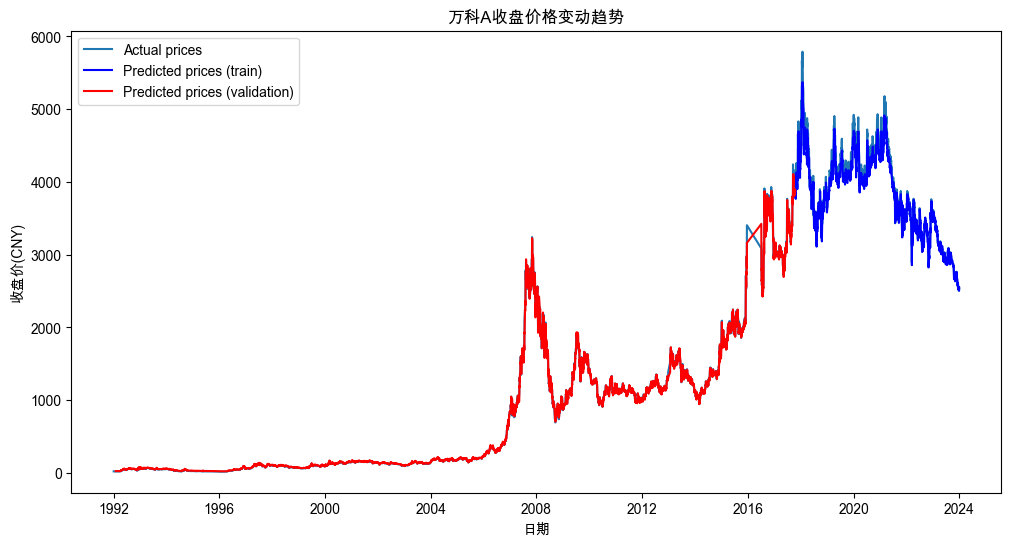

In [143]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_date, y=data_close_price, label='Actual prices')
sns.lineplot(x=data_date, y=to_plot_data_y_val_pred, label='Predicted prices (train)', color='blue')
sns.lineplot(x=data_date, y=to_plot_data_y_train_pred, label='Predicted prices (validation)', color='red')
plt.title('万科A收盘价格变动趋势')
plt.xlabel('日期')
plt.ylabel('收盘价(CNY)')
plt.legend()
plt.show()

使用以下代码重点关注验证数据集部分

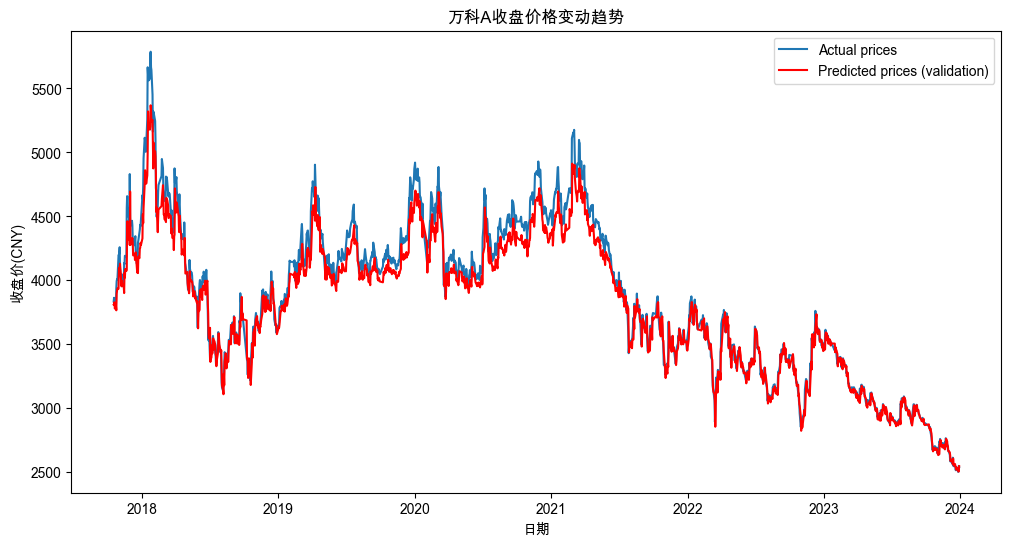

In [144]:
to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+window_size_use:]

plt.figure(figsize=(12, 6))
sns.lineplot(x=to_plot_data_date, y=to_plot_data_y_val_subset, label='Actual prices')

sns.lineplot(x=to_plot_data_date, y=to_plot_predicted_val, label='Predicted prices (validation)', color='red')
plt.title('万科A收盘价格变动趋势')
plt.xlabel('日期')
plt.ylabel('收盘价(CNY)')
plt.legend()
plt.show()

## 预测未来股票价格

到目前为止，我们已经训练了一个 LSTM 模型，该模型可以（相当准确地）根据过去 20 天的收盘价格预测第二天的价格。这意味着我们现在手中有一个水晶球！让我们将过去 20 天的收盘价格输入模型，看看它对下一个交易日（即未来）的预测结果。

/var/folders/dv/ly5hp_ms3bd9753868lg6c5w0000gn/T/ipykernel_15110/952509082.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)


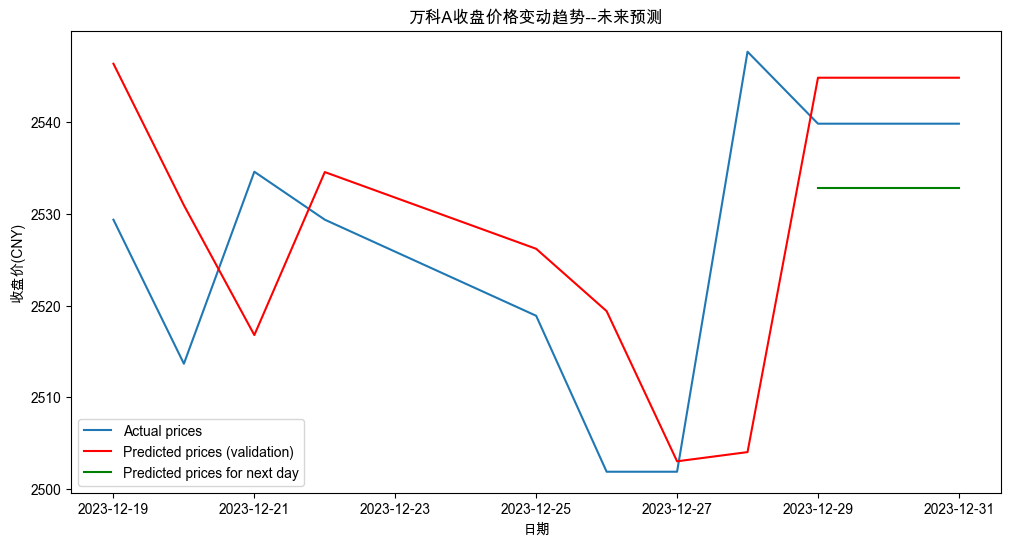

Predicted close price of the next trading day: 2532.83


In [145]:
import datetime

# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(training_device).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]

# plot_date_test.add(datetime.date(2023,12,30))
new_data = pd.Series({7570: datetime.date(2023,12,31)})
plot_date_test = pd.concat([plot_date_test,new_data])
plt.figure(figsize=(12, 6))
sns.lineplot(x=plot_date_test, y=to_plot_data_y_val, label='Actual prices')

sns.lineplot(x=plot_date_test, y=to_plot_data_y_val_pred, label='Predicted prices (validation)', color='red')

sns.lineplot(x=plot_date_test, y=to_plot_data_y_test_pred, label='Predicted prices for next day', color='green')
plt.title('万科A收盘价格变动趋势--未来预测')
plt.xlabel('日期')
plt.ylabel('收盘价(CNY)')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))

References
Full project.py source code: link

To submit your questions or comments via GitHub Issues: [link](https://github.com/jinglescode/time-series-forecasting-pytorch/blob/main/project.py)

To run the script on a Google Colab Jupyter notebook with access to GPU: [link](https://colab.research.google.com/github/jinglescode/time-series-forecasting-pytorch/blob/main/demo-predicting-stock-prices.ipynb)

To run the script on your local Jupyter Notebook:

git clone https://github.com/jinglescode/time-series-forecasting-pytorch.git
pip install -r requirements.txt